# Porto Seguro Safe Driver Data Set

This Jupyter Notebook includes data preprocessing and EDA for the Porto Seguro Safe Driver Data Set. It also trains machine learning models in two categories: supervised and unsupervised. 

For each category, we have tried different models and you can select your desired parameters for running the notebook in the variables down below: 

In [1]:
# Select your wanted category: 'supervised', 'unsupervised'
category = 'supervised' 

### FOR SUPERVISED ###
# Select Undersampling method: 'no', 'random', 'nearmiss', 'cnn'
undersampling = 'nearmiss'
# 'mlp', 'decisiontree', 'knearestneighbour', 'svm'
model = 'mlp'

Data Import, Preprocessing and EDA is conducted in the same way for both categories. 

## Data Import and EDA

### Import the Data

Import all libraries needed for the project, and import the data into a dataframe. 

In [2]:
# Importing needed libraries 
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

# For scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Deal with imbalanced dataset 
import imblearn


# Import the dataset
dataset = pd.read_csv('data/train.csv', index_col='id')
# Create dataframe
df = pd.DataFrame(dataset)
# Check dataset
df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Double-check the amount of data we have. 
df.shape

(595212, 58)

### Data Overview

Get an overview of the number and types of values in the dataset and create a features summary.

In [4]:
# Get information about every single column in our data. 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

In [5]:
summary = pd.DataFrame(df.dtypes, columns=['data types'])
# Calculate the number of missing values
summary['# missing values'] = (df == -1).sum().values 
# Number of unique values by features
summary['# unique values'] = df.nunique().values # -> eg. target as 2 unique values as it is 

# Get the type of data in each column
variable_types = []
for col in df.columns: 
    if 'bin' in col or col == 'target':
        variable_types.append('binary')
    elif 'cat' in col: 
        variable_types.append('nominal') 
    elif df[col].dtype == float: 
        variable_types.append('continuous')
    elif df[col].dtype == np.int64:
        variable_types.append('categorical')
summary['variable type'] = variable_types

# View the top of this dataframe
summary.head()

,data types,# missing values,# unique values,variable type
target,int64,0,2,binary
ps_ind_01,int64,0,8,categorical
ps_ind_02_cat,int64,216,5,nominal
ps_ind_03,int64,0,12,categorical
ps_ind_04_cat,int64,83,3,nominal


In [6]:
# Get the names of the columns of a certain variable type 
summary[summary['variable type'] == 'nominal'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

### Value Distributions Visualisation

#### Target Value

Check how balanced (or not) the target value is among the training data.

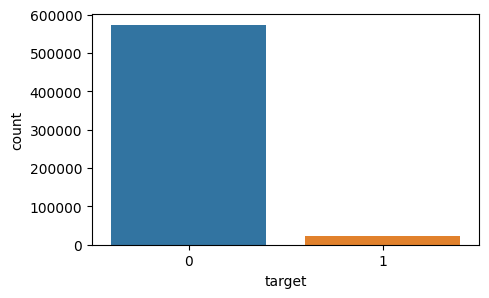

In [7]:
plt.figure(figsize=(5, 3))

ax = sns.countplot(df, x='target') # countplot: Show the counts of observations in each categorical bin using bars.

#### Feature Distribution

How is each feature distributed looking at the target values? 

In [8]:
def plot_target_ratio_by_feat(datatype='binary', legend='on'): 
    """
    This function plots all features of one datatype against the target value. It presents an overview of how frequently each feature is represented in the target value. 

    Parameters:
    - datatype: The type of features to plot. Options are 'binary', 'nominal', 'continuous', 'categorical'. 
    - legend: 'on' or 'off' to turn on or off printing the legend in the plot. 

    Returns:
    - A plot showing the distribution of each feature in the target value. 
    """
    cols = summary[summary['variable type'] == datatype].index
    ncols = 4
    nrows = len(cols) // ncols if len(cols) % ncols == 0 else len(cols) // ncols + 1
    # Create grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))
    axes = axes.flatten() # Flatten the axes array for easy iteration
    
    for i, feature in enumerate(df[cols]):
        sns.countplot(df, x='target', hue=feature, ax=axes[i])
        # turn off legend if set
        if legend == 'off':
            axes[i].legend().set_visible(False)
        # set the title for each subplot
        axes[i].set_title(f'Countplot for {col}')
    
    plt.tight_layout()

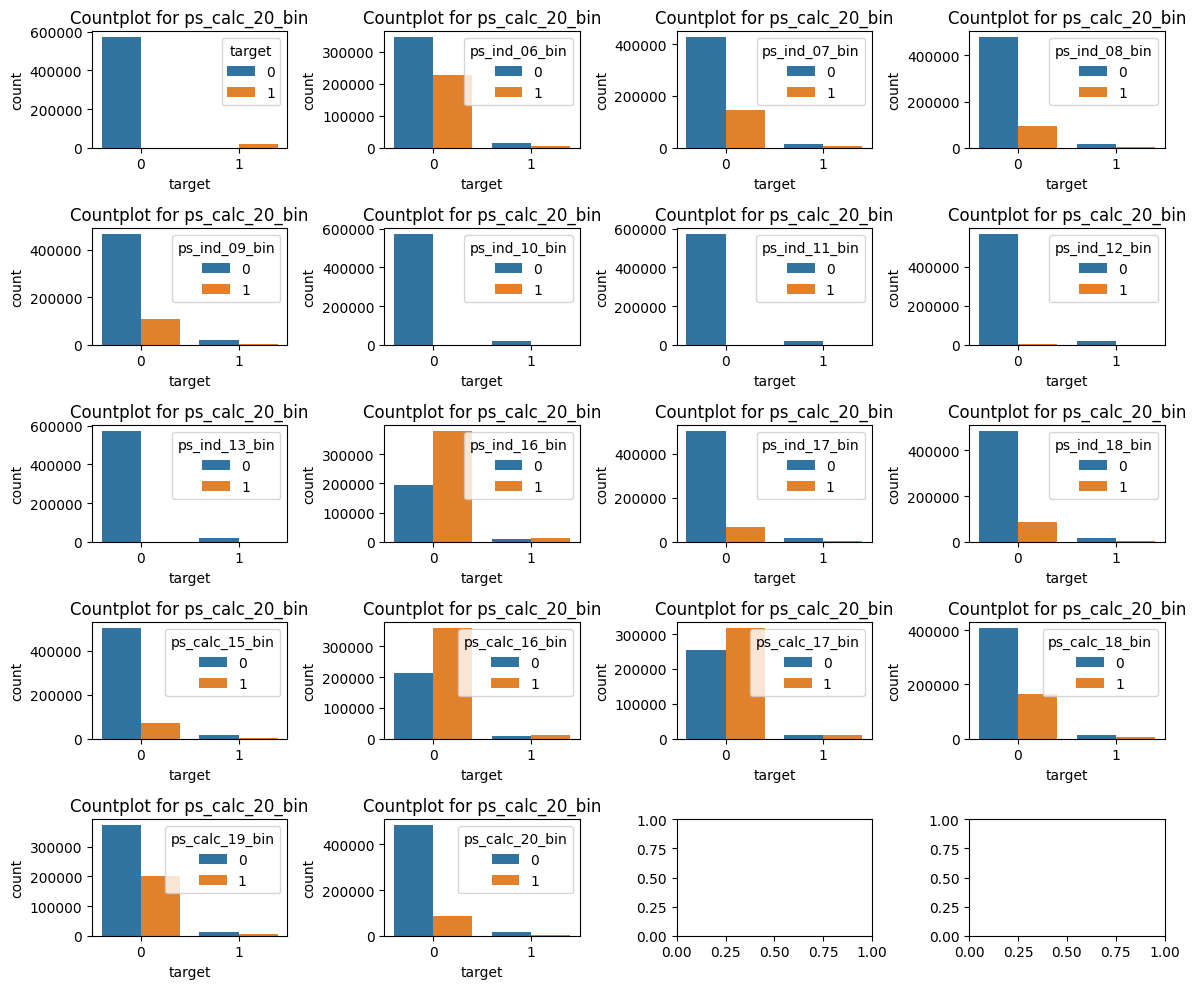

In [9]:
plot_target_ratio_by_feat(datatype='binary')

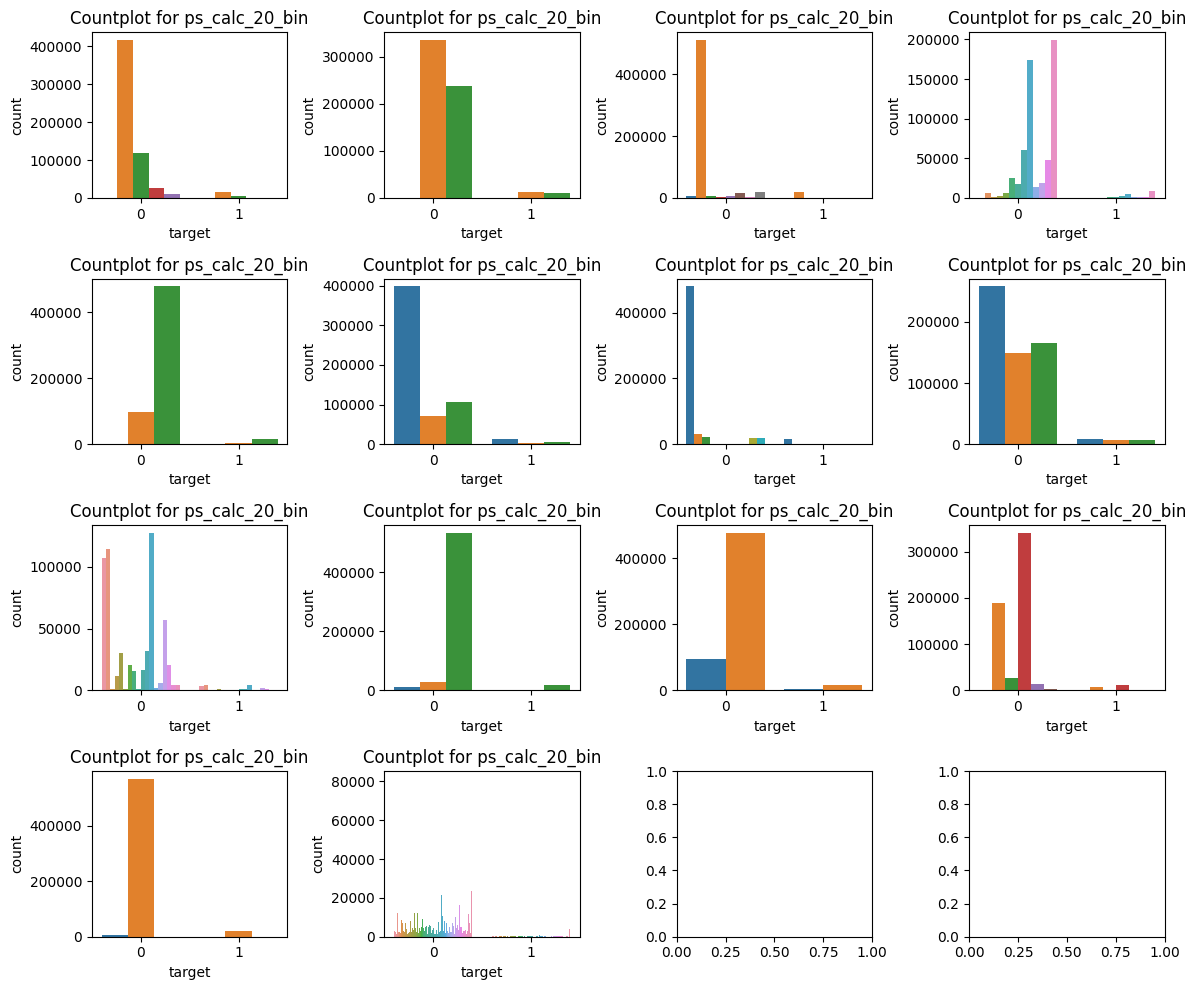

In [10]:
plot_target_ratio_by_feat(datatype='nominal', legend='off')

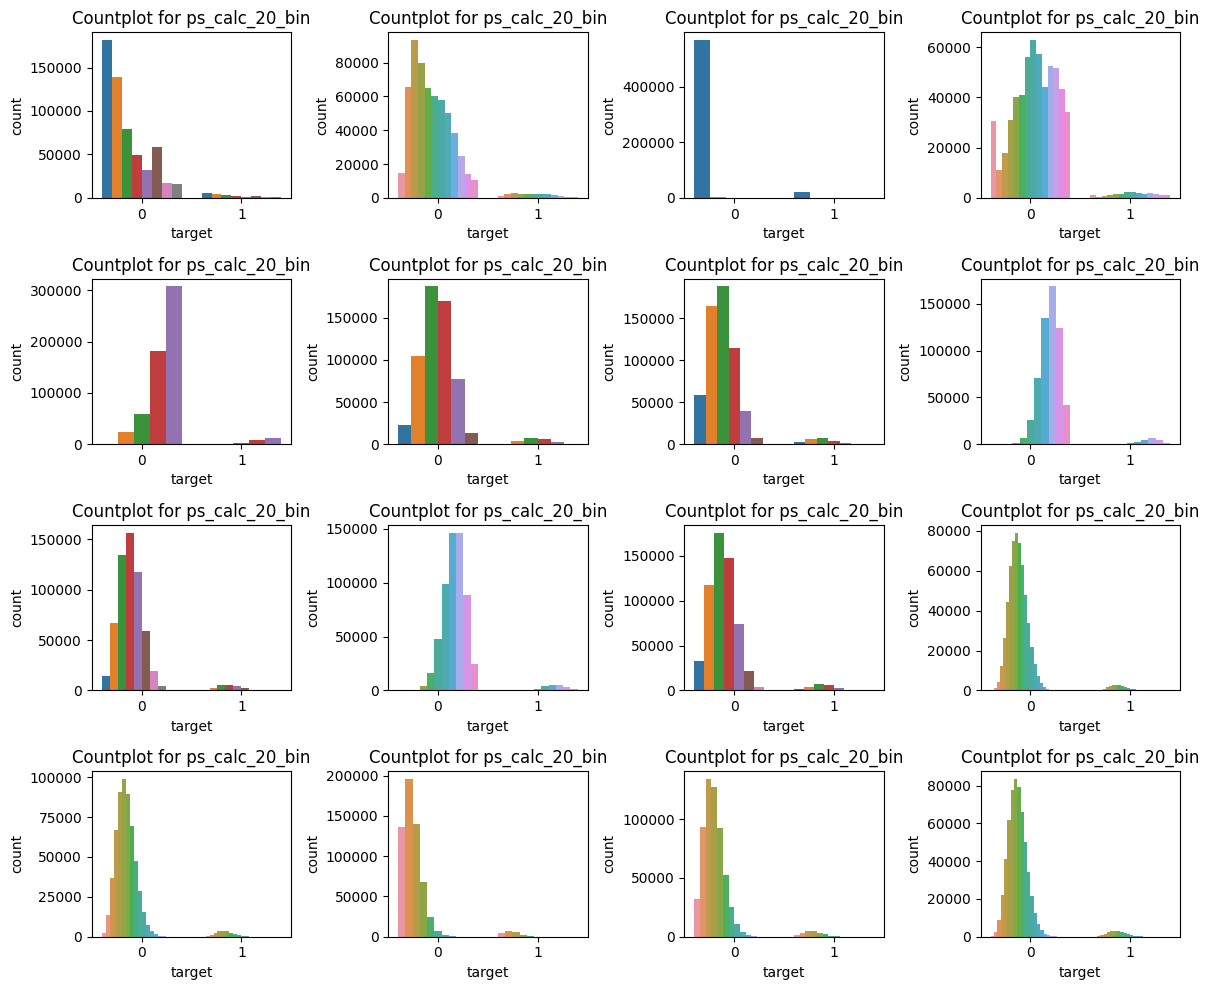

In [11]:
plot_target_ratio_by_feat(datatype='categorical', legend='off')

### Remove Missing Values 

Remove the missing values 

In [12]:
# Remove missing values: All our missing data is marked with -1
df.replace(-1, np.NaN, inplace=True) # Replace the -1 values with NaN
df.dropna(inplace=True) # Remove NaN values

### Correlation Matrix

Check the correlation among continuous features. 

<AxesSubplot:>

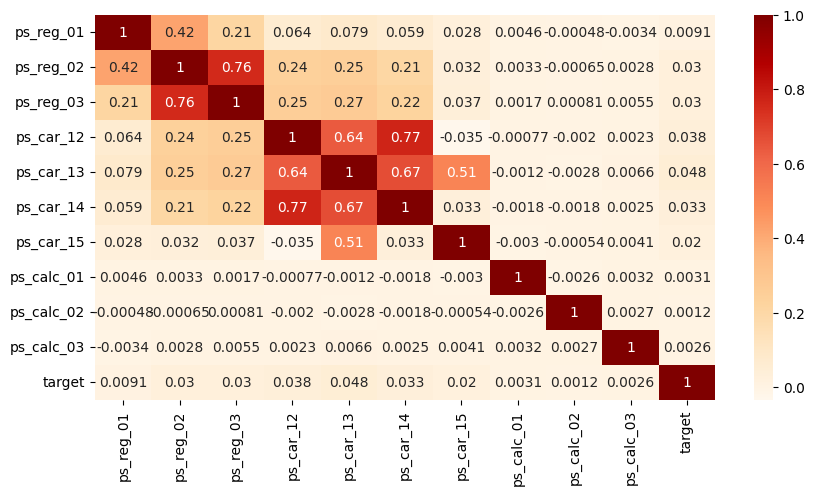

In [13]:
# Find correlating features: 
plt.figure(figsize=(10, 5))
c = df[summary[summary['variable type'] == 'continuous'].index.append(summary[summary.index == 'target'].index)].corr() # Compute pairwise correlation of columns
sns.heatmap(c, annot=True, cmap='OrRd')

The correlation matrix shows that none of the features on their own has a strong correlation with the target value. 

### Undersampling

To combat the uneven distribution of target values and prevent our model from classifying everything into 0. 

Undersampling is a technique to balance the target value distribution for a classification dataset that has a skewed target (= class) distribution. 
Undersampling removes examples from the training dataset that belong to the majority class (in our case: no insurance claim (0)) in order to better balance the class distribution (e.g., reducing the skew from 1:100 to 1:10, 1:2, or even 1:1). 

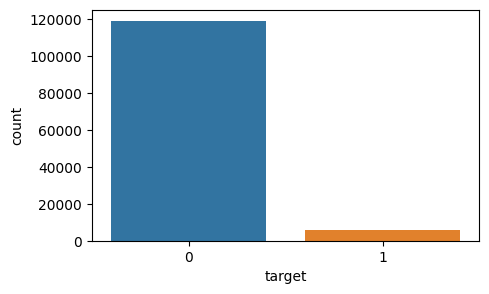

In [14]:
# Plot the original distribution of the target values again
plt.figure(figsize=(5, 3))
ax = sns.countplot(df, x='target')

#### No Undersampling

In [15]:
if (undersampling == 'no'):
    X = df.iloc[:, 1:]
    y = df.iloc[:, :1]

#### Random Undersampling

Simply removes randomly selected examples from the training data. However, it might remove useful information: The major drawback of random undersampling is that this method can discard potentially useful data that could be important for the induction process. 

In [16]:
if (undersampling == 'random'):
    # Random Undersampling 
    print('Shape of data:', df.shape)
    print('Number of entries with classification 0:', df[df['target'] == 0].shape[0])
    print('Number of entries with classification 1:', df[df['target'] == 1].shape[0])

    # Select 5670 entries from the 0 target value entries 
    X = df[df['target'] == 0].iloc[:5670, 1:].append(df[df['target'] == 1].iloc[:, 1:]) # Take the first 5670 entries of 0 + all of 1
    y = df[df['target'] == 0].iloc[:5670, :1].append(df[df['target'] == 1].iloc[:, :1]) 

#### Near Miss Undersampling

Near Miss is an undersampling method based on the distance of the majority class examples to the minority class examples. The default number of neighbours in NearMiss is 3. 

1. `NearMiss-1` selects examples from the majority class that have the smallest average distance to the three closest examples from the minority class. 
2. `NearMiss-2` selects the positive samples for which the average distance to the N farthest samples of the negative class is the smallest. 

In [17]:
if (undersampling == 'nearmiss'):
    from imblearn.under_sampling import NearMiss
    # Define undersampling method 
    undersample = NearMiss(version=2)
    # Resample 
    X, y = undersample.fit_resample(df.iloc[:, 1:], df.iloc[:, :1])

#### Condensed Nearest Neighbour Undersampling 

CNN for shot is an undersampling technique that seeks a subset of a collection of samples that results in no loss in model performance, referred to as a minimal set. 

### Split into Train and Testing Sets

In [18]:
# Split into train and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Removing Outliers

Removes all outliers from `X_train` and `y_train`. 

In [19]:
# To remove outliers: first identify outliers in the training dataset
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X_train) # Label is 1 for an inlier and -1 for an outlier
inlier_indexes = y_pred == 1 # select all rows that are not outliers

# Remove from X_train and y_train
X_train, y_train = X_train[inlier_indexes], y_train[inlier_indexes]

### Scaling the Data

Scale the data so that each columns values are on a common scale. We wrote the helper method below to quickly scale the data. It allows you to select either standardisation or normalisation. 

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_data(X_train, X_test=None, scaling_type='sta'):
    """
    This function scales the input data using either MinMax scaling or Standard scaling.

    Parameters:
    - X_train: The training data.
    - X_test: The testing data (optional).
    - scaling_type: The type of scaler to use, either 'mm' for MinMax Scaling or 'sta' for Standard Scaling.

    Returns:
    - Scaled X_train and X_test (if provided).

    Example:
    >>> X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scaling_type='mm')
    """

    if scaling_type == 'mm':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        if X_test is not None:
            X_test_scaled = scaler.transform(X_test)
    elif scaling_type == 'sta':
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        if X_test is not None:
            X_test_scaled = scaler.transform(X_test)
    else:
        return "No correct scaling method."

    if X_test is not None:
        print("Scaled data, size of X_train:", X_train_scaled.shape, "size of X_test:", X_test_scaled.shape)
        return X_train_scaled, X_test_scaled
    else:
        print("Scaled data, size of X:", X_train_scaled.shape)
        return X_train_scaled

In [21]:
X_train, X_test = scale_data(X_train, X_test)

Scaled data, size of X_train: (8164, 57) size of X_test: (2268, 57)


In [22]:
print("Size of y_train:", y_train.shape, "size of y_test:", y_test.shape) # Sanity check of sizes

Size of y_train: (8164, 1) size of y_test: (2268, 1)


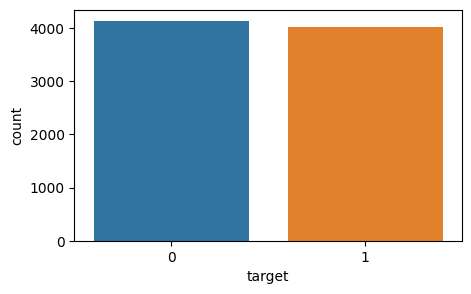

In [23]:
# Plot the distribution of target values after undersampling. 
plt.figure(figsize=(5, 3))
ax = sns.countplot(pd.DataFrame(y_train), x='target')

## Supervised Learning - Model Selection

### Neural Networks for Classification 

Classification with scikit's `MLPClassifier`, which implements a multi-layer perceptron algorithm that trains using Backpropagation [[Source]](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

I'm going to try with both the normalised and the standardised data.

In [24]:
if (model == 'mlp'):
    from sklearn.neural_network import MLPClassifier

    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X_train, y_train) # Train the classifier 

    y_pred = clf.predict(X_test)

c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
# Method to reuse for every evaluation to get accuracy, confusion matrix, sensitivity & specificity, recall & precision, F1-Score, ROC curve.
def getMetrics(y_true, y_pred):
    """
    This helper function evaluates the accuracy, confusion matrix, sensitivity & specificity, recall & precision, F1-Score, ROC curve for a given prediction against the true target values. 

    Parameters:
    - y_true: The true target values. 
    - y_pred: The predicted target values by the model. 

    Returns:
    - metrics: Dataframe containing the metrics. Also prints the confusion matrix and ROC curve. 
    """
    # Keeping track of all the metrics. 
    metrics = pd.DataFrame()

    # For the accuracy. 
    from sklearn.metrics import accuracy_score
    metrics['accuracy'] = [accuracy_score(y_true, y_pred)]
    
    # Confusion Matrix. 
    from sklearn.metrics import confusion_matrix
    con_matrix = confusion_matrix(y_true, y_pred)
    print(con_matrix)
    
    # True Positive, False Positive, True Negative, False Negative
    metrics['TP'] = con_matrix[0][0]
    metrics['FP'] = con_matrix[0][1]
    metrics['TN'] = con_matrix[1][1]
    metrics['FN'] = con_matrix[1][0]
    
    # Sensitivity & Specificity
    metrics['sensitivity'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])
    metrics['specificity'] = metrics['TN'] / (metrics['TN'] + metrics['FP'])

    # For recall & precision. 
    from sklearn.metrics import precision_score, recall_score

    metrics['precision'] = [precision_score(y_true, y_pred)]
    metrics['recall'] = [recall_score(y_true, y_pred)]

    # F-measure. 
    from sklearn.metrics import f1_score
    metrics['f1-score'] = [f1_score(y_true, y_pred)]

    # ROC area. 
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve

    metrics['roc-area'] = [roc_auc_score(y_true, y_pred)]

    import matplotlib.pyplot as plt
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    #create ROC curve
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return metrics

### Nearest Neighbour

Remember: small number of neighbours leads to low bias, high variance (overfitting), a big number of neighbours leads to high bias, low variance and underfitting. 

In [26]:
if (model == 'nearestneighbour'):
    from sklearn.neighbors import KNeighborsRegressor

    clf = KNeighborsRegressor(n_neighbors=5)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1, 0)

### Decision Trees

In [27]:
if (model == 'decisiontree'):
    from sklearn import tree

    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

### Support Vector Machines 

In [28]:
if (model == 'svm'):
    from sklearn import svm
    
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

#### SVM Tuning

### Model Evaluation 

We can look at the following classification metrics: 

1. Accuracy
2. Precision and Recall
3. F1-Score
4. ROC-AUC (The area under the receiver operating characteristic curve. It shows the capability of a model to distinguish between classes.)

Text(0.5, 1.0, 'Confusion Matrix')

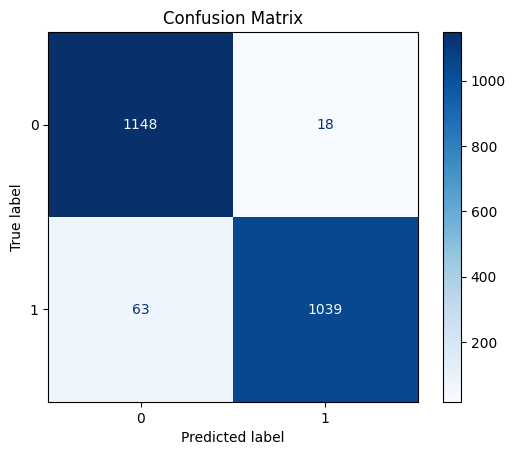

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Confusion Matrix")

[[1148   18]
 [  63 1039]]


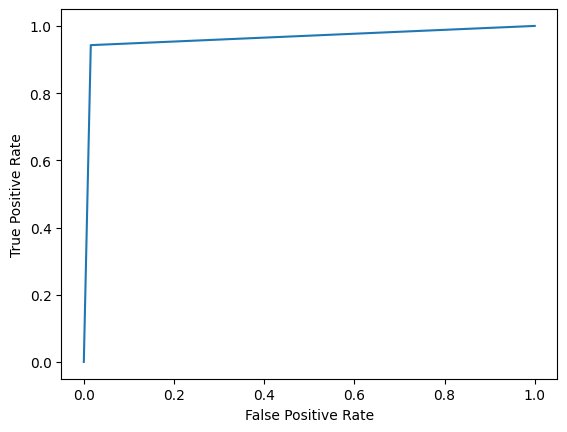

,accuracy,TP,FP,TN,FN,sensitivity,specificity,precision,recall,f1-score,roc-area
0,0.964286,1148,18,1039,63,0.947977,0.982971,0.982971,0.942831,0.962483,0.963697


In [30]:
getMetrics(y_test, y_pred)

### Validation 

There are different methods to validate the model: 

1. Holdout Method
2. K-Fold Cross-Validation
3. Startified and Time-Series Splits

In [31]:
# K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5) # Perform cross-validation

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
scores

c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum ite

0.93 accuracy with a standard deviation of 0.02


c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([0.89109347, 0.95502646, 0.94400353, 0.94444444, 0.90917108])

## Unsupervised Learning - Model Selection

### K-means

K-means helps find natural groups in data, but it doesn't use yes-no labels directly. It's useful for discovering patterns, even in binary-labeled data, offering insights beyond simple classification.

In [36]:
# import the library
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

In [40]:
# Unsupervised learning 
X = scale_data(np.concatenate([X_train, X_test], axis=0))
X.shape

Scaled data, size of X: (10432, 57)


(10432, 57)

### Elbow method 

The elbow method helps find the optimal number of clusters in K-means 

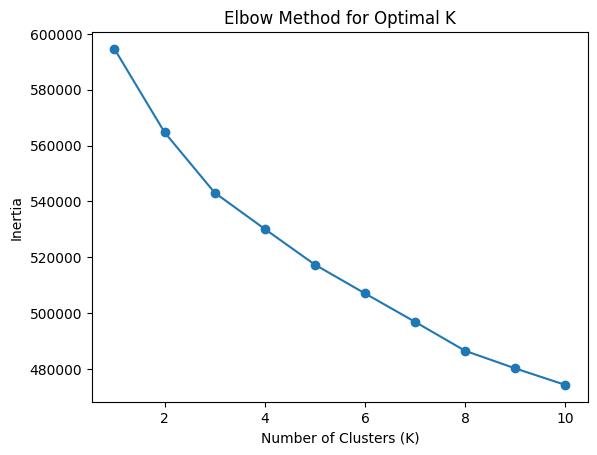

Optimal number of clusters (K): 3


In [41]:
# Initialize a range of cluster numbers to try
num_clusters_range = range(1, 11)
inertia_values = []

# Fit KMeans for each cluster number and store the inertia
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values to find the elbow
plt.plot(num_clusters_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Find the optimal K based on the elbow analysis
diff = np.diff(inertia_values)
diff_r = diff[1:] / diff[:-1]
optimal_k = num_clusters_range[np.argmin(diff_r) + 1]

# Print the optimal K
print(f'Optimal number of clusters (K): {optimal_k}')

### Apply with K-means

In [42]:
# optimal_k = 2  

# Fit KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=1)
cluster_labels_optimal = kmeans_optimal.fit_predict(X)

# Add the cluster labels to the existing dataframe
df['Cluster'] = pd.Series(cluster_labels_optimal)

# Visualize the clustered data in 2D using PCA with plotly
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a new dataframe for visualization
df_visualize = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_visualize['Cluster'] = cluster_labels_optimal.astype(str)

# Visualize the clustered data using plotly
fig = px.scatter(df_visualize, x='PC1', y='PC2', color='Cluster', title=f'K-means Clustering (K={optimal_k}) with Plotly')
fig.update_layout(xaxis_title='', yaxis_title='')  # Remove x and y labels
fig.show()


### Evaluation

Silhouette Score measures how well-separated clusters are in K-means, providing a concise evaluation of cluster cohesion and separation.

The score:

Near 1: The clusters are well-separated.

Near 0: Overlapping clusters.

Near -1: Incorrect cluster assignments.


In [43]:
from sklearn.metrics import silhouette_score

# Assuming X contains your feature matrix and df contains your dataframe

# Choose the number of clusters 
num_clusters = optimal_k  # Use the optimal K obtained from the elbow analysis

# Fit KMeans to the original data (without scaling)
kmeans = KMeans(n_clusters=num_clusters, random_state=1)
cluster_labels = kmeans.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.05638696156120466


A Silhouette Score of 0.05 indicates overlapping clusters in data. This suggests that instances within different clusters have similarities, making it challenging for the unsupervised model to create well-separated clusters. Overlapping may occur due to the nature of your features or the inherent ambiguity in yes-no labeled data, where distinct patterns are harder to discern.